<a href="https://colab.research.google.com/github/cfitzpatrick89/ADS509-Final/blob/main/ADS509_Final_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xmltodict
!pip install pyLDAvis

import pandas as pd
import xmltodict
import requests
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import os
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string
import json
from sklearn.decomposition import NMF
import gensim
from gensim import corpora
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.gensim_models
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt



# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Set of stop words
stop_words = set(stopwords.words('english'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.4 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
import nltk
nltk.download('vader_lexicon')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Create Directory

In [3]:
# Function to create a directory
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created successfully.")
    else:
        print(f"Directory '{directory}' already exists.")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Pubmed IDs

In [4]:
import requests

def fetch_pubmed_ids(query, from_date, to_date, max_results=250):
    search_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    search_params = {
        "db": "pubmed",
        "term": query,
        "retmode": "json",
        "retmax": max_results,
        "mindate": from_date,
        "maxdate": to_date

    }
    response = requests.get(search_url, params=search_params)
    if response.status_code == 200:
        data = response.json()
        return data['esearchresult']['idlist']
    else:
        print(f"Error fetching PubMed IDs: {response.status_code} - {response.reason}")
        return []

# Example usage:
pubmed_ids = fetch_pubmed_ids('climate change health', '2023/01/01', '2023/12/31')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
def fetch_pubmed_details(ids, batch_size=250):
    fetch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    xml_data_list = []
    for i in range(0, len(ids), batch_size):
        batch_ids = ids[i:i + batch_size]
        fetch_params = {
            "db": "pubmed",
            "id": ",".join(batch_ids),
            "retmode": "xml"
        }
        response = requests.get(fetch_url, params=fetch_params)
        if response.status_code == 200:
            xml_data_list.append(response.text)
        else:
            print(f"Error fetching PubMed details for batch {i//batch_size + 1}: {response.status_code} - {response.reason}")
    return xml_data_list

# Example usage:
pubmed_xml = fetch_pubmed_details(pubmed_ids)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Parse Data

In [6]:
import xmltodict

def extract_text_from_abstract(abstract):
    if isinstance(abstract, list):
        text_list = []
        for item in abstract:
            if isinstance(item, dict):
                text_list.append(item.get('#text', ''))
            else:
                text_list.append(item)
        return ' '.join(text_list)
    elif isinstance(abstract, dict):
        return abstract.get('#text', '')
    else:
        return abstract

def parse_pubmed_details(xml_data_list):
    articles = []
    for xml_data in xml_data_list:
        data_dict = xmltodict.parse(xml_data)
        for article in data_dict['PubmedArticleSet']['PubmedArticle']:
            try:
                pmid = article['MedlineCitation']['PMID']
                title = article['MedlineCitation']['Article']['ArticleTitle']
                abstract = article['MedlineCitation']['Article']['Abstract']['AbstractText']
                abstract_text = extract_text_from_abstract(abstract)
                articles.append({
                    'PMID': pmid,
                    'Title': title,
                    'Abstract': abstract_text
                })
            except KeyError:
                continue
    return articles

# Example usage:
articles = parse_pubmed_details(pubmed_xml)
df_articles = pd.DataFrame(articles)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
df_articles

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,PMID,Title,Abstract
0,"{'@Version': '1', '#text': '38156221'}",Perspectives on research needs in healthcare e...,"In this overview, we articulate research needs..."
1,"{'@Version': '1', '#text': '38155328'}",Reducing the carbon footprint of cataract surg...,Climate change is arguably the greatest threat...
2,"{'@Version': '1', '#text': '38154019'}",Assessing Support for Policy Actions With Co-B...,Calls to action addressing the interconnection...
3,"{'@Version': '1', '#text': '38153962'}",Heat Exposure among Adult Women in Rural Tamil...,Exposure to heat is associated with a substant...
4,"{'@Version': '1', '#text': '38153847'}",Physiological responses to 9 hours of heat exp...,Older adults are at greater risk of heat-relat...
...,...,...,...
222,"{'@Version': '1', '#text': '38049304'}","Trends, Future Directions, and Questions for P...",Many nurse educators enter the faculty role wi...
223,"{'@Version': '1', '#text': '38048966'}",Technical and Administrative Advances to Promo...,Climate change mandates that we take steps to ...
224,"{'@Version': '1', '#text': '38048878'}","Environmental-, Climate-, and Health-Related D...",Plant-based diets can have co-benefits for hum...
225,"{'@Version': '1', '#text': '38048345'}",Effects of temperature on the life history tra...,The impact of climate change has led to variat...


### Preprocess Text

In [9]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

# Example usage:
df_articles['processed_abstract'] = df_articles['Abstract'].apply(preprocess_text)
df_articles['processed_abstract_str'] = df_articles['processed_abstract'].apply(lambda x: ' '.join(x))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Descriptive Statistics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of tokens: 32613
Number of unique tokens: 6209
Average token length: 7.35
Most common tokens: [('health', 457), ('climate', 439), ('the', 332), ('change', 322), ('we', 161), ('environmental', 148), ('study', 145), ('temperature', 138), ('this', 134), ('research', 115)]


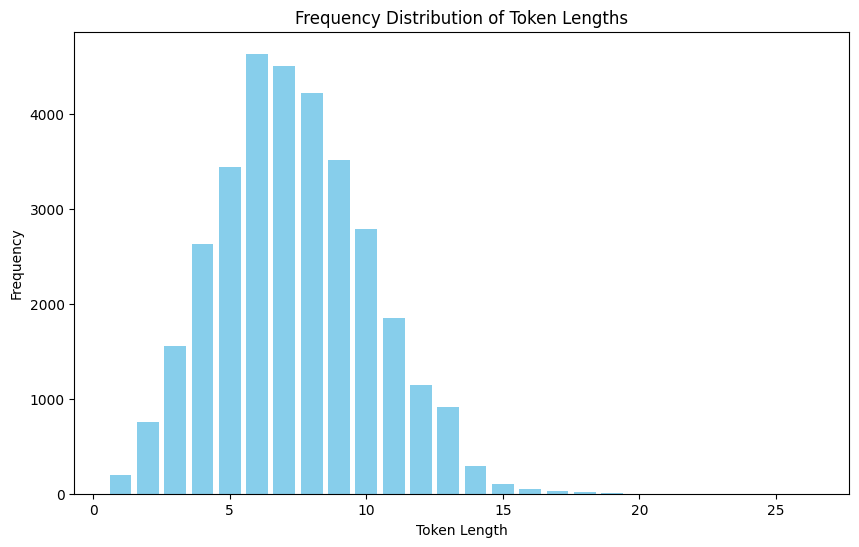

In [12]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

def calculate_descriptive_statistics(df, text_column):
    all_text = " ".join(df[text_column])
    tokens = word_tokenize(all_text)
    num_tokens = len(tokens)
    unique_tokens = set(tokens)
    num_unique_tokens = len(unique_tokens)
    avg_token_length = sum(len(token) for token in tokens) / num_tokens
    token_freq = Counter(tokens)
    most_common_tokens = token_freq.most_common(10)
    token_length_freq = Counter(len(token) for token in tokens)

    print(f"Number of tokens: {num_tokens}")
    print(f"Number of unique tokens: {num_unique_tokens}")
    print(f"Average token length: {avg_token_length:.2f}")
    print(f"Most common tokens: {most_common_tokens}")

    token_length_df = pd.DataFrame(token_length_freq.items(), columns=['Token Length', 'Frequency']).sort_values(by='Token Length')
    return token_length_df

# Example usage:
token_length_df = calculate_descriptive_statistics(df_articles, 'processed_abstract_str')

# Plot the frequency distribution of token lengths
plt.figure(figsize=(10, 6))
plt.bar(token_length_df['Token Length'], token_length_df['Frequency'], color='skyblue')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Token Lengths')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average number of unique tokens per abstract: 103.03
Average sentence length: 143.67 tokens


<ipython-input-13-b635a2211675>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Frequency', data=token_freq_df, palette='viridis')


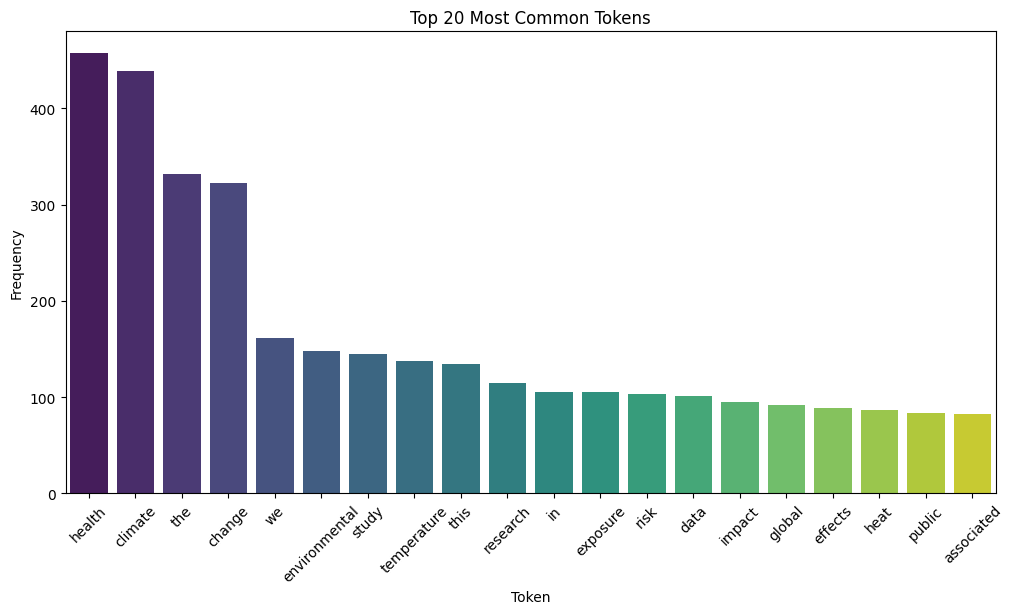

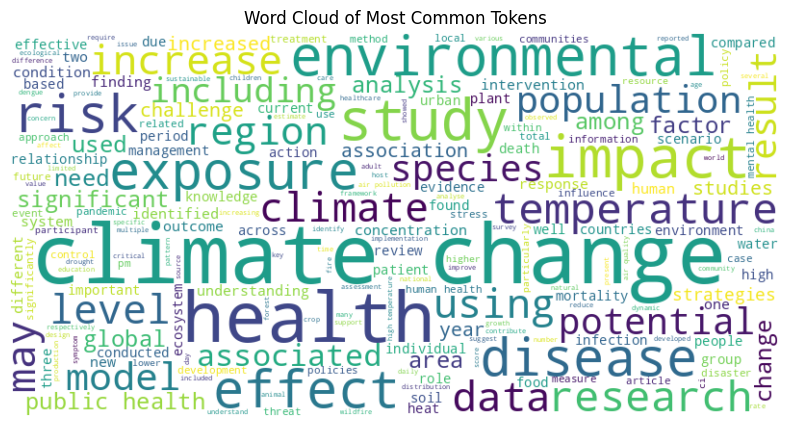

In [13]:
import numpy as np
from wordcloud import WordCloud

def calculate_advanced_statistics(df, text_column):
    all_text = " ".join(df[text_column])
    tokens = word_tokenize(all_text)

    # Token frequency distribution
    token_freq = Counter(tokens)

    # Unique tokens per abstract
    df['unique_tokens'] = df[text_column].apply(lambda x: len(set(word_tokenize(x))))
    avg_unique_tokens = df['unique_tokens'].mean()

    # Average sentence length
    sentences = [sentence for text in df[text_column] for sentence in text.split('.')]
    sentence_lengths = [len(word_tokenize(sentence)) for sentence in sentences]
    avg_sentence_length = np.mean(sentence_lengths)

    # Display results
    print(f"Average number of unique tokens per abstract: {avg_unique_tokens:.2f}")
    print(f"Average sentence length: {avg_sentence_length:.2f} tokens")

    # Token frequency distribution plot
    token_freq_df = pd.DataFrame(token_freq.most_common(20), columns=['Token', 'Frequency'])
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Token', y='Frequency', data=token_freq_df, palette='viridis')
    plt.xlabel('Token')
    plt.ylabel('Frequency')
    plt.title('Top 20 Most Common Tokens')
    plt.xticks(rotation=45)
    plt.show()

    # Word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Most Common Tokens')
    plt.show()

    return avg_unique_tokens, avg_sentence_length

# Example usage:
if df_articles is not None:
    df_articles['processed_abstract_str'] = df_articles['processed_abstract'].apply(lambda x: ' '.join(x))
    avg_unique_tokens, avg_sentence_length = calculate_advanced_statistics(df_articles, 'processed_abstract_str')
else:
    print("DataFrame is empty. No articles to process.")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


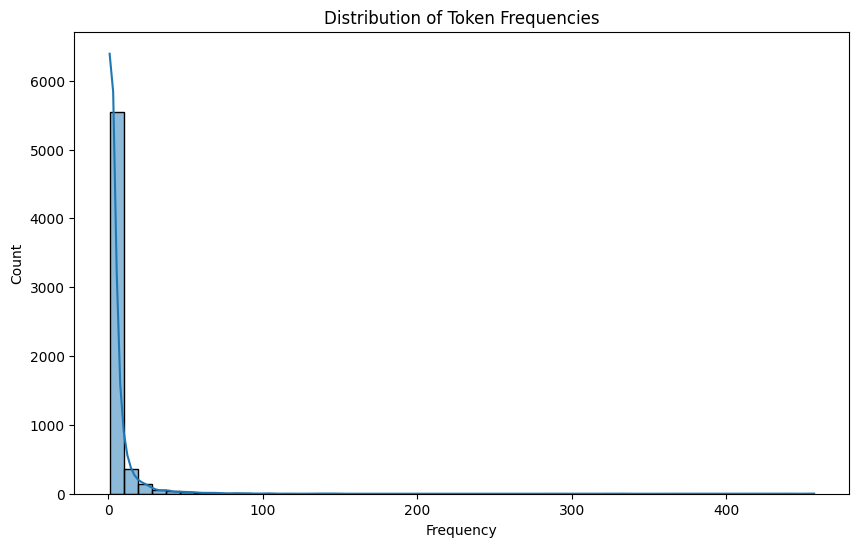

In [14]:
def plot_token_frequencies(df, text_column):
    all_text = " ".join(df[text_column])
    tokens = word_tokenize(all_text)
    token_freq = Counter(tokens)

    token_freq_df = pd.DataFrame(token_freq.values(), columns=['Frequency'])
    plt.figure(figsize=(10, 6))
    sns.histplot(token_freq_df['Frequency'], bins=50, kde=True)
    plt.xlabel('Frequency')
    plt.ylabel('Count')
    plt.title('Distribution of Token Frequencies')
    plt.show()

# Example usage:
plot_token_frequencies(df_articles, 'processed_abstract_str')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


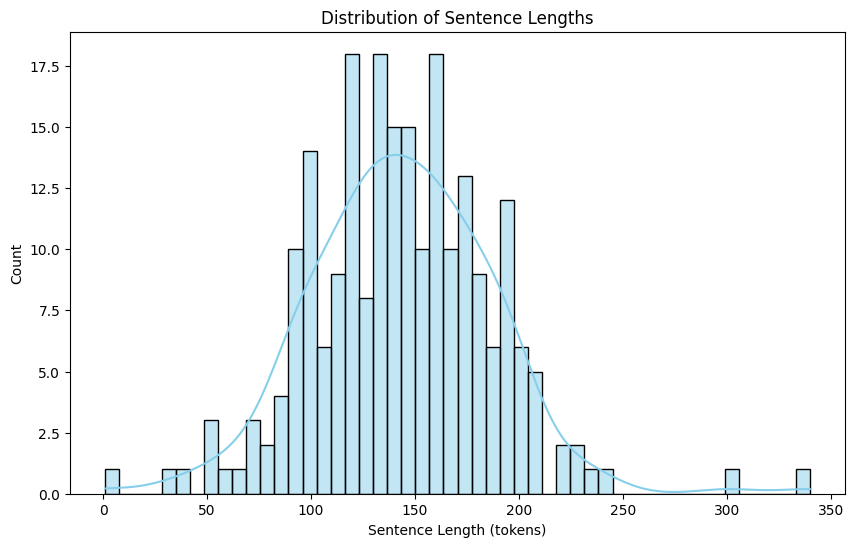

In [15]:
def plot_sentence_lengths(df, text_column):
    sentences = [sentence for text in df[text_column] for sentence in text.split('.')]
    sentence_lengths = [len(word_tokenize(sentence)) for sentence in sentences]

    plt.figure(figsize=(10, 6))
    sns.histplot(sentence_lengths, bins=50, kde=True, color='skyblue')
    plt.xlabel('Sentence Length (tokens)')
    plt.ylabel('Count')
    plt.title('Distribution of Sentence Lengths')
    plt.show()

# Example usage:
plot_sentence_lengths(df_articles, 'processed_abstract_str')


## Topic Modeling

In [16]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Ensure we have TF-IDF and NMF installed
!pip install scikit-learn
!pip install xmltodict

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Topic Modeling Functions

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
import pyLDAvis
import pyLDAvis
import matplotlib.pyplot as plt
import numpy as np

def nmf_topic_modeling(text_data, num_topics=5, num_top_words=10):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(text_data)
    nmf = NMF(n_components=num_topics, random_state=1)
    nmf.fit(tfidf)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

    for topic_idx, topic in enumerate(nmf.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([tfidf_feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

    return nmf, tfidf_vectorizer  # Return two values


def lda_topic_modeling(text_data, num_topics=5, num_top_words=10):
    count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    count_data = count_vectorizer.fit_transform(text_data)
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=1)
    lda.fit(count_data)
    count_feature_names = count_vectorizer.get_feature_names_out()

    for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([count_feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

    return lda, count_vectorizer

def lsa_topic_modeling(text_data, num_topics=5, num_top_words=10):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(text_data)
    lsa = TruncatedSVD(n_components=num_topics, random_state=1)
    lsa.fit(tfidf)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

    for topic_idx, topic in enumerate(lsa.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([tfidf_feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

    return lsa, tfidf_vectorizer,

def visualize_lda_topics(lda_model, count_data, count_vectorizer):
    panel = pyLDAvis.sklearn.prepare(lda_model, count_data, count_vectorizer, mds='tsne')
    pyLDAvis.display(panel)
    return panel



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 6), sharex=True)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx + 1}', fontsize=14)
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
    fig.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.90, wspace=0.3)
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### NMF

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 1:
health climate change adaptation environmental public research challenges policy strategies
Topic 2:
temperature heat mortality risk cold ci high days deaths morbidity
Topic 3:
species plant water soil microbial growth stress environmental study food
Topic 4:
air pm pollution exposure smoke levels quality wildfires skin wildfire
Topic 5:
built environment pediatric care children health physical design disparities pediatricians


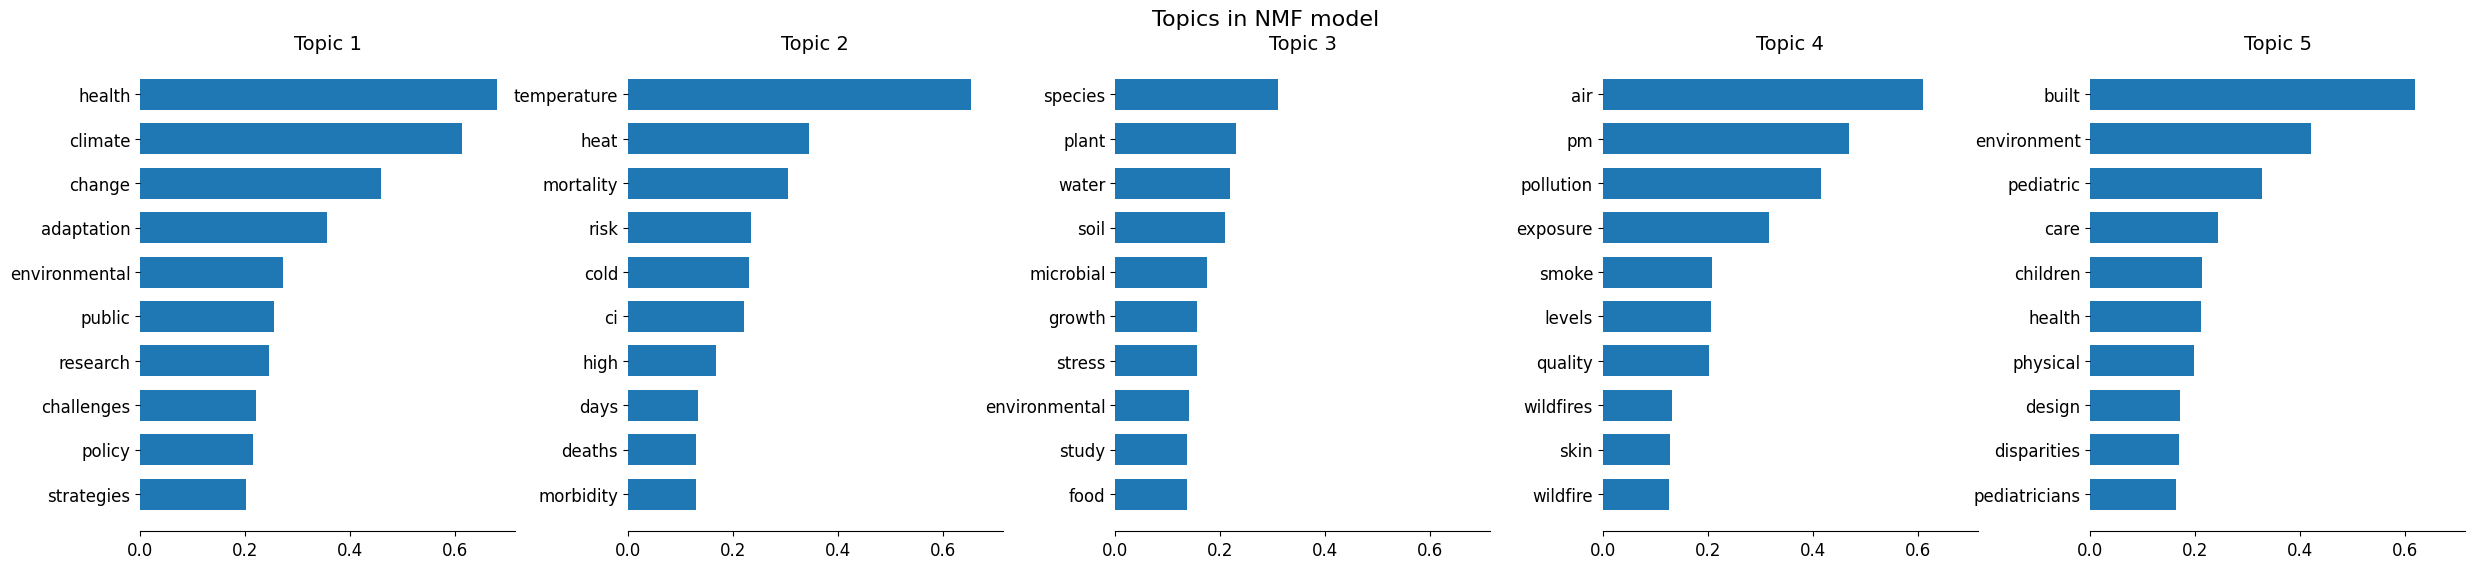

In [19]:
# Example usage:
nmf, tfidf_vectorizer = nmf_topic_modeling(df_articles['processed_abstract_str'], num_topics=5, num_top_words=10)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(nmf, tfidf_feature_names, 10, 'Topics in NMF model')

### LDA

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 1:
climate change species study carbon soil research environmental health microbial
Topic 2:
climate health change environmental stress model global species exposure high
Topic 3:
health climate change risk heat temperature study research impact data
Topic 4:
climate health change adults temperature exposure levels ci depression symptoms
Topic 5:
health climate change environmental mental air environment knowledge temperature study


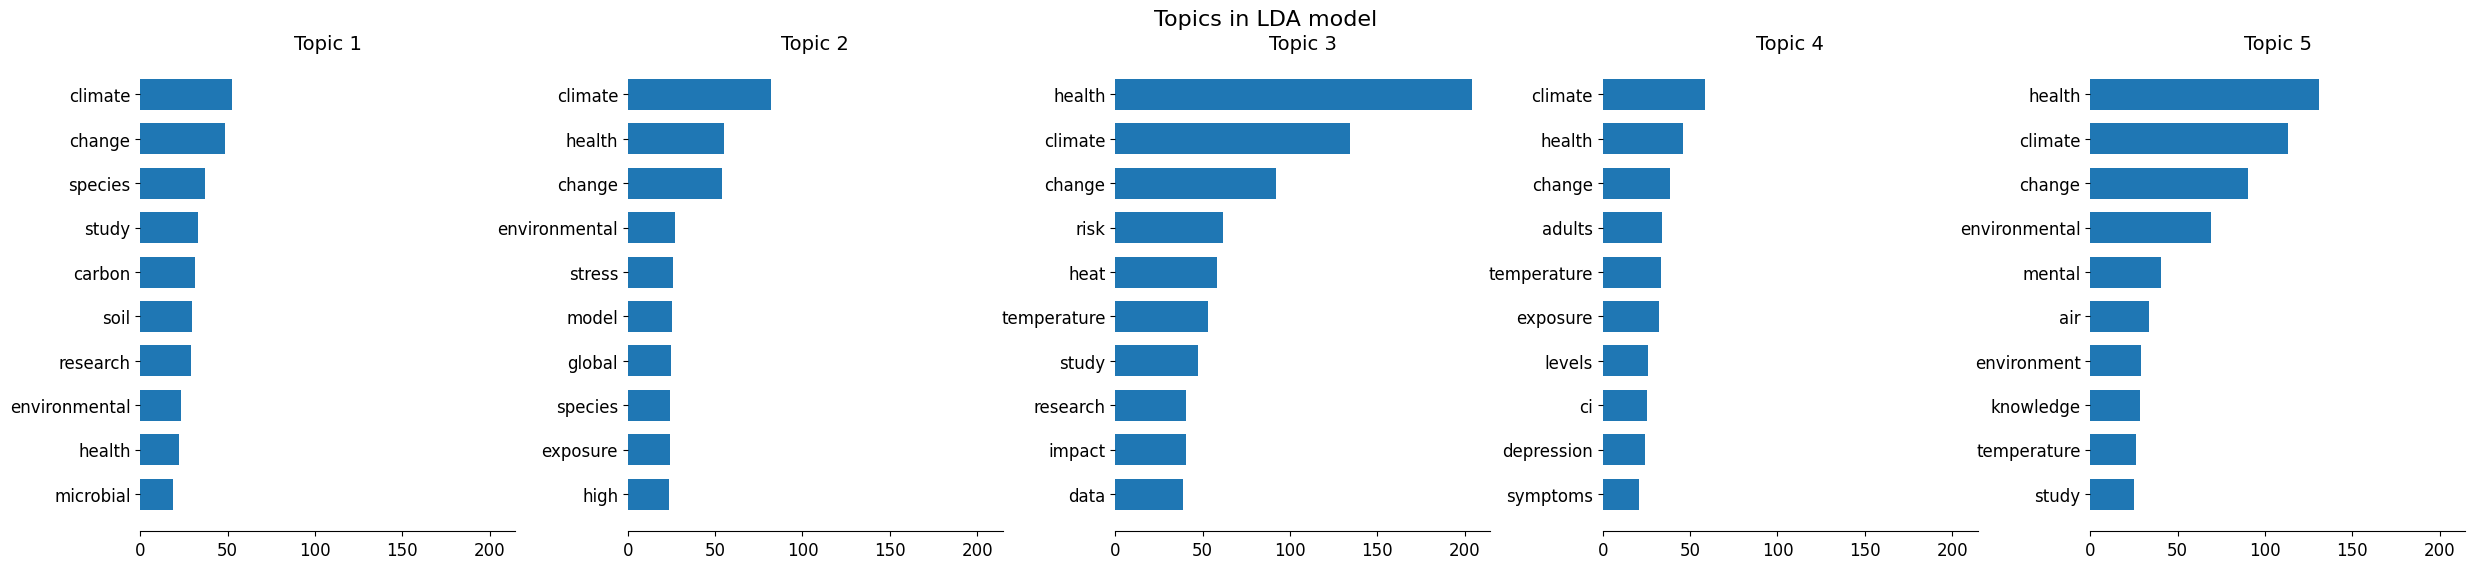

In [20]:
# Example usage with LDA
lda, count_vectorizer = lda_topic_modeling(df_articles['processed_abstract_str'], num_topics=5, num_top_words=10)
count_feature_names = count_vectorizer.get_feature_names_out()
plot_top_words(lda, count_feature_names, 10, 'Topics in LDA model')

### LSA

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 1:
health climate change temperature environmental heat research exposure global risk
Topic 2:
temperature exposure pm ci mortality heat cold risk air days
Topic 3:
species plant soil water microbial growth environmental food se ecological
Topic 4:
air pollution pm exposure built quality levels smoke environment children
Topic 5:
built environment mental children pediatric physical care anxiety stress depression


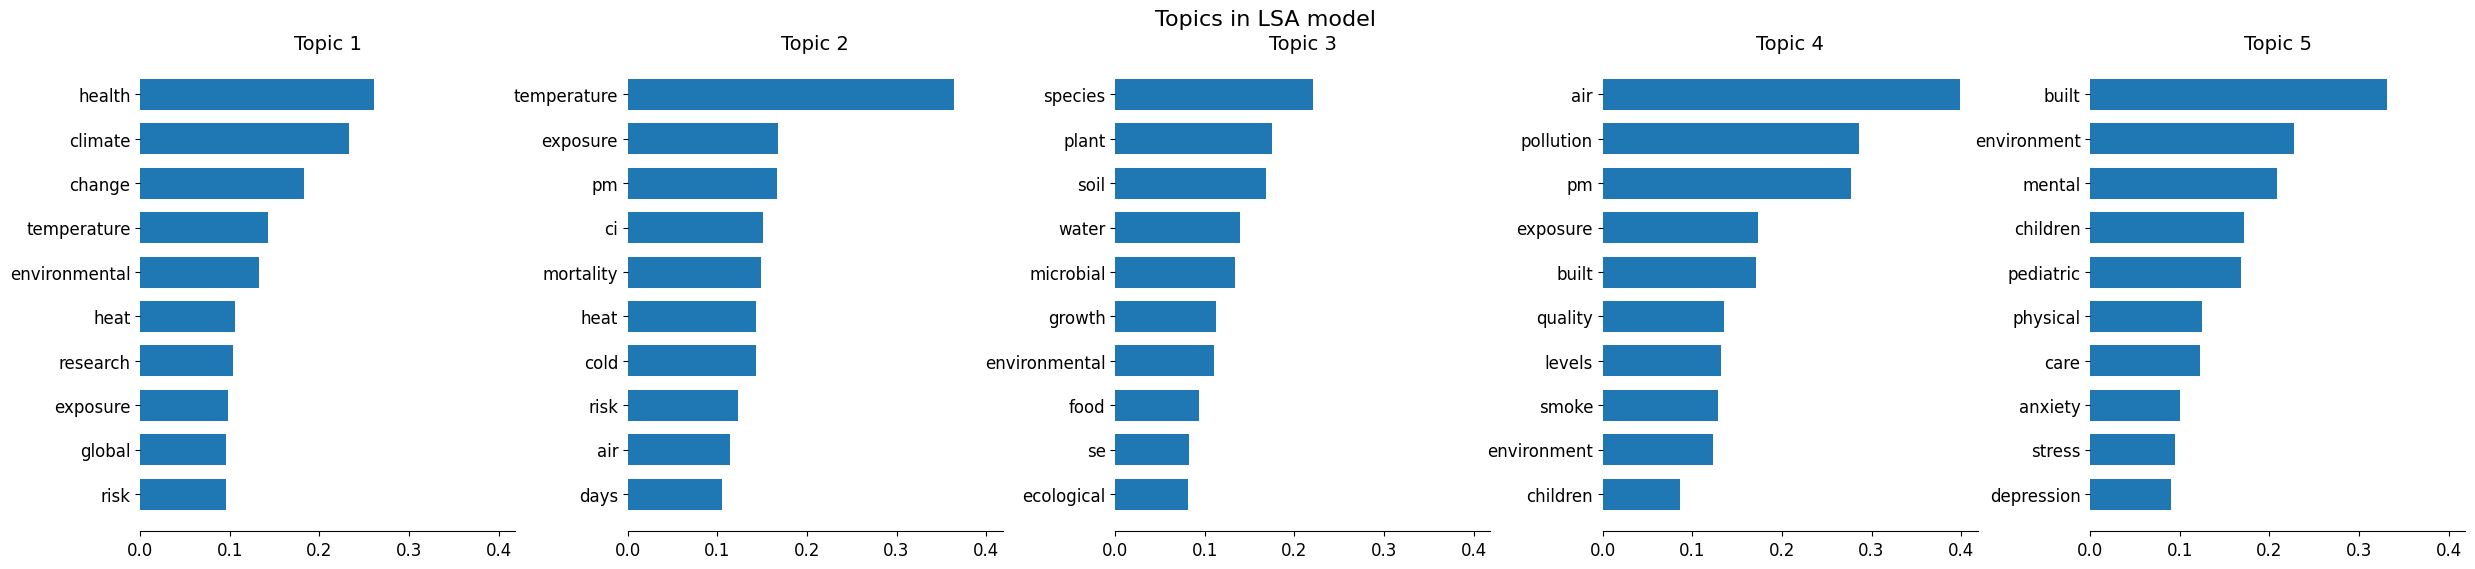

In [21]:
# Example usage with LSA
lsa, tfidf_vectorizer = lsa_topic_modeling(df_articles['processed_abstract_str'], num_topics=5, num_top_words=10)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(lsa, tfidf_feature_names, 10, 'Topics in LSA model')


### LDA Panel Visualization

In [39]:
def lda_topic_modeling(text_data, num_topics=5, num_top_words=10):
    count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    count_data = count_vectorizer.fit_transform(text_data)
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=1)
    lda.fit(count_data)
    count_feature_names = count_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([count_feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
    # Prepare the data for pyLDAvis
    pyLDAvis_data = pyLDAvis.lda_model.prepare(lda, count_data, count_vectorizer)  # Updated method
    return pyLDAvis_data

# Call the function to get the visualization data
lda_panel = lda_topic_modeling(df_articles['processed_abstract_str'], num_topics=5)

# Display the visualization
pyLDAvis.display(lda_panel)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 1:
climate change species study carbon soil research environmental health microbial
Topic 2:
climate health change environmental stress model global species exposure high
Topic 3:
health climate change risk heat temperature study research impact data
Topic 4:
climate health change adults temperature exposure levels ci depression symptoms
Topic 5:
health climate change environmental mental air environment knowledge temperature study


### Chose Topic 1 & 3 from NMF

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


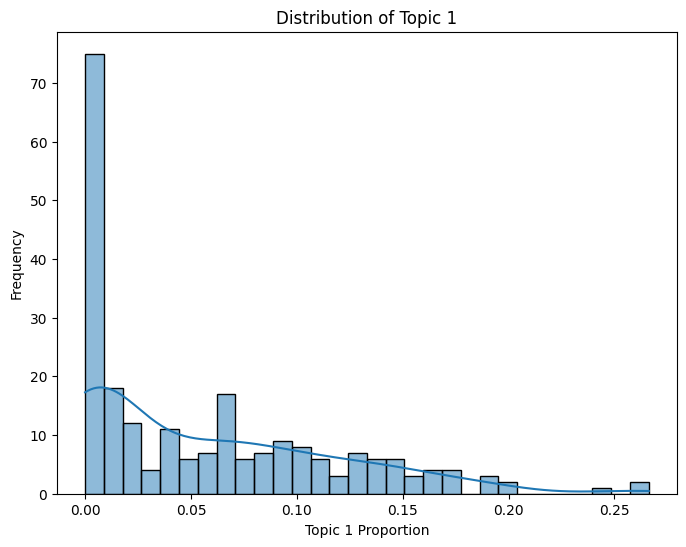

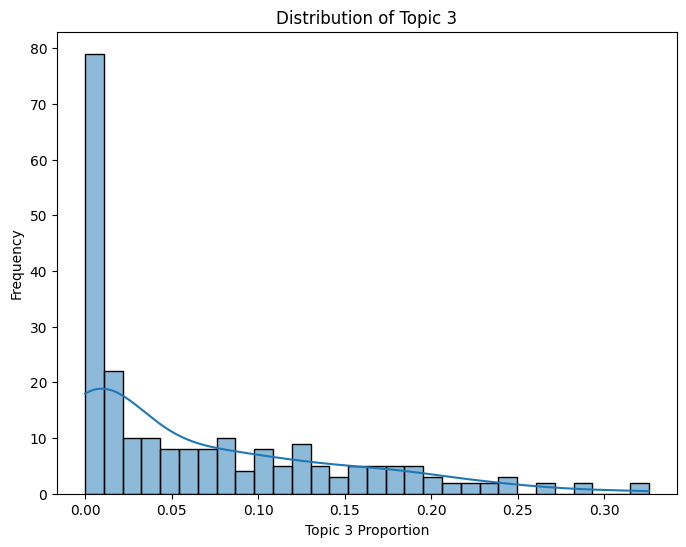

In [30]:
# Plot distribution of the first two topics
def plot_topic_distribution(topic_distribution, topic_idx, title):
    plt.figure(figsize=(8, 6))
    sns.histplot(topic_distribution[:, topic_idx], bins=30, kde=True)
    plt.title(title)
    plt.xlabel(f'Topic {topic_idx + 1} Proportion')
    plt.ylabel('Frequency')
    plt.show()

# Get the topic distribution for each document
W = nmf.transform(tfidf_vectorizer.transform(text_data))

# Plot distributions of Topic 1 and Topic 3
plot_topic_distribution(W, 0, 'Distribution of Topic 1')
plot_topic_distribution(W, 2, 'Distribution of Topic 3')

## Classification Models

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np

# Step 1: Get Topic Distribution
def get_topic_distribution(nmf_model, tfidf):
    topic_distribution = nmf_model.transform(tfidf)
    return topic_distribution

# Step 2: Create Labels for Topic 1 and 3
def create_labels(topic_distribution, topic_indices):
    labels = []
    for dist in topic_distribution:
        dominant_topic = np.argmax(dist)
        if dominant_topic in topic_indices:
            labels.append(dominant_topic)
        else:
            labels.append(-1)  # Label as -1 for topics not 1 or 3
    return np.array(labels)

text_data = df_articles['processed_abstract_str']

# Fit NMF model
nmf, tfidf_vectorizer = nmf_topic_modeling(text_data, num_topics=5, num_top_words=10)

# Transform the text data to get the TFIDF matrix
tfidf = tfidf_vectorizer.transform(text_data)

# Get topic distribution
topic_distribution = get_topic_distribution(nmf, tfidf)

# Create labels
topic_indices = [0, 2]  # Topics 1 and 3 (0-indexed)
labels = create_labels(topic_distribution, topic_indices)

# Filter data
filtered_indices = np.where(labels != -1)
filtered_labels = labels[filtered_indices]
filtered_data = tfidf[filtered_indices]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 1:
health climate change adaptation environmental public research challenges policy strategies
Topic 2:
temperature heat mortality risk cold ci high days deaths morbidity
Topic 3:
species plant water soil microbial growth stress environmental study food
Topic 4:
air pm pollution exposure smoke levels quality wildfires skin wildfire
Topic 5:
built environment pediatric care children health physical design disparities pediatricians


In [26]:
nmf

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NMF(n_components=5, random_state=1)

### Train Test Val Split

In [27]:
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(filtered_data, filtered_labels, test_size=0.3, random_state=19)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Logistic Regression

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
import numpy as np

# Logistic Regression with Cross-Validation and Hyperparameter Tuning
pipeline = Pipeline([
    ('clf', LogisticRegression(random_state=42))
])

param_grid = {
    'clf__C': [0.1, 1, 10, 100],
    'clf__solver': ['newton-cg', 'lbfgs', 'liblinear']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)
print("Validation Set Evaluation:")
print(classification_report(y_val, y_val_pred))

y_test_pred = best_model.predict(X_test)
print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best parameters: {'clf__C': 1, 'clf__solver': 'liblinear'}
Best cross-validation score: 0.9813852813852814
Validation Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           2       0.83      1.00      0.91        10

    accuracy                           0.91        23
   macro avg       0.92      0.92      0.91        23
weighted avg       0.93      0.91      0.91        23

Test Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           2       1.00      1.00      1.00        15

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



### Random Forest

In [40]:
# Random Forest with Cross-Validation and Hyperparameter Tuning
pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))
])

param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)
print("Validation Set Evaluation:")
print(classification_report(y_val, y_val_pred))

y_test_pred = best_model.predict(X_test)
print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best parameters: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Best cross-validation score: 0.9160173160173161
Validation Set Evaluation:
              precision    recall  f1-score   support

           0       0.91      0.77      0.83        13
           2       0.75      0.90      0.82        10

    accuracy                           0.83        23
   macro avg       0.83      0.83      0.83        23
weighted avg       0.84      0.83      0.83        23

Test Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           2       0.94      1.00      0.97        15

    accuracy                           0.96        23
   macro avg       0.97      0.94      0.95        23
weighted avg       0.96      0.96      0.96        23



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Extracting feature importances
feature_importances = best_model.named_steps['clf'].feature_importances_
features = tfidf_vectorizer.get_feature_names_out()

# Creating a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sorting the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Selecting the top 15 features
top_15_features = importance_df.head(15)

# Plotting the top 15 feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_15_features['Feature'], top_15_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()



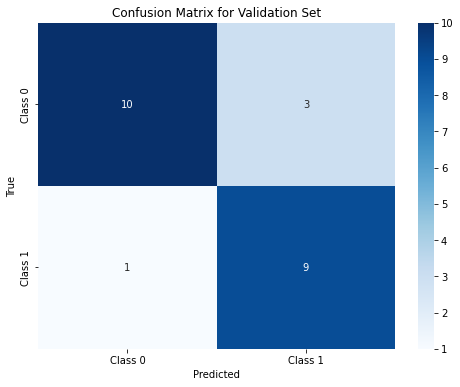

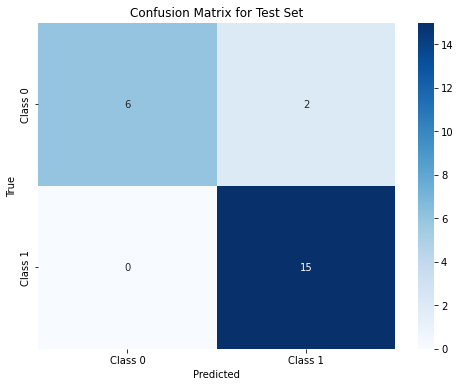

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Plotting confusion matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_val, y_val_pred, "Confusion Matrix for Validation Set")
plot_confusion_matrix(y_test, y_test_pred, "Confusion Matrix for Test Set")

# Sentiment Analysis

In [ ]:
def sentiment_analysis(text_data):
    # Initialize VADER sentiment analyzer
    sid = SentimentIntensityAnalyzer()

    # Create a list to store sentiment scores
    sentiments = []

    # Loop through the text data
    for text in text_data:
        # Calculate sentiment scores
        sentiment_scores = sid.polarity_scores(text)
        sentiments.append(sentiment_scores)

    return sentiments

# Perform sentiment analysis
sentiment_scores = sentiment_analysis(df_articles['processed_abstract_str'])

# Convert the sentiment scores to a DataFrame
df_sentiments = pd.DataFrame(sentiment_scores)

# Combine the sentiment scores with the original DataFrame
df_combined = pd.concat([df_articles, df_sentiments], axis=1)

# Display the DataFrame with sentiment scores
print(df_combined.head())

                                     PMID  \
0  {'@Version': '1', '#text': '38156221'}   
1  {'@Version': '1', '#text': '38155328'}   
2  {'@Version': '1', '#text': '38154019'}   
3  {'@Version': '1', '#text': '38153962'}   
4  {'@Version': '1', '#text': '38153847'}   

                                               Title  \
0  Perspectives on research needs in healthcare e...   
1  Reducing the carbon footprint of cataract surg...   
2  Assessing Support for Policy Actions With Co-B...   
3  Heat Exposure among Adult Women in Rural Tamil...   
4  Physiological responses to 9 hours of heat exp...   

                                            Abstract  \
0  In this overview, we articulate research needs...   
1  Climate change is arguably the greatest threat...   
2  Calls to action addressing the interconnection...   
3  Exposure to heat is associated with a substant...   
4  Older adults are at greater risk of heat-relat...   

                                  processed_abstract  \

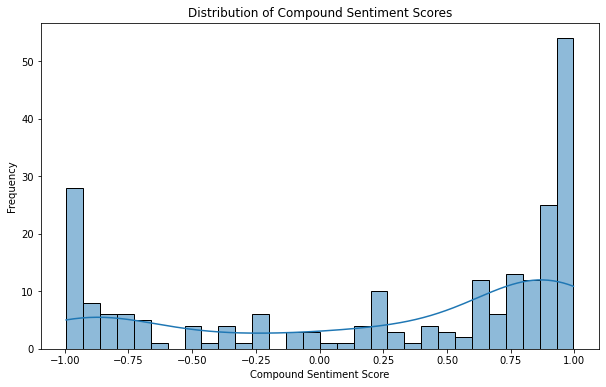

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_sentiment(df):
    plt.figure(figsize=(10, 6))

    # Plotting the distribution of sentiment scores
    sns.histplot(df['compound'], bins=30, kde=True)
    plt.title('Distribution of Compound Sentiment Scores')
    plt.xlabel('Compound Sentiment Score')
    plt.ylabel('Frequency')

    plt.show()

# Example usage
visualize_sentiment(df_combined)


### Top Keywords

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def extract_keywords(texts, top_n=10):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=top_n)
    X = vectorizer.fit_transform(texts)
    keywords = vectorizer.get_feature_names_out()
    return keywords

# Example usage
keywords = extract_keywords(df_articles['processed_abstract_str'], top_n=20)
print("Top Keywords:", keywords)


Top Keywords: ['associated' 'change' 'climate' 'data' 'disease' 'effects'
 'environmental' 'exposure' 'global' 'health' 'heat' 'impact' 'impacts'
 'public' 'research' 'risk' 'species' 'study' 'temperature' 'using']


In [42]:
# import pandas as pd
# import xmltodict
# import requests
# import nltk
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# import pyLDAvis
# import pyLDAvis.lda_model
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Ensure NLTK resources are downloaded
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('vader_lexicon')

# stop_words = set(stopwords.words('english'))

# def fetch_pubmed_ids(query, from_date, to_date, max_results=100):
#     search_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
#     search_params = {
#         "db": "pubmed",
#         "term": query,
#         "retmode": "json",
#         "retmax": max_results,
#         "mindate": from_date,
#         "maxdate": to_date
#     }
#     response = requests.get(search_url, params=search_params)
#     if response.status_code == 200:
#         data = response.json()
#         return data['esearchresult']['idlist']
#     else:
#         print(f"Error fetching PubMed IDs: {response.status_code} - {response.reason}")
#         return []

# def fetch_pubmed_details(ids, batch_size=100):
#     fetch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
#     xml_data_list = []
#     for i in range(0, len(ids), batch_size):
#         batch_ids = ids[i:i + batch_size]
#         fetch_params = {
#             "db": "pubmed",
#             "id": ",".join(batch_ids),
#             "retmode": "xml"
#         }
#         response = requests.get(fetch_url, params=fetch_params)
#         if response.status_code == 200:
#             xml_data_list.append(response.text)
#         else:
#             print(f"Error fetching PubMed details for batch {i//batch_size + 1}: {response.status_code} - {response.reason}")
#     return xml_data_list

# def extract_text_from_abstract(abstract):
#     if isinstance(abstract, list):
#         text_list = []
#         for item in abstract:
#             if isinstance(item, dict):
#                 text_list.append(item.get('#text', ''))
#             else:
#                 text_list.append(item)
#         return ' '.join(text_list)
#     elif isinstance(abstract, dict):
#         return abstract.get('#text', '')
#     else:
#         return abstract

# def parse_pubmed_details(xml_data_list):
#     articles = []
#     for xml_data in xml_data_list:
#         data_dict = xmltodict.parse(xml_data)
#         for article in data_dict['PubmedArticleSet']['PubmedArticle']:
#             try:
#                 pmid = article['MedlineCitation']['PMID']
#                 title = article['MedlineCitation']['Article']['ArticleTitle']
#                 abstract = article['MedlineCitation']['Article']['Abstract']['AbstractText']
#                 abstract_text = extract_text_from_abstract(abstract)
#                 journal = article['MedlineCitation']['Article']['Journal']['Title']
#                 articles.append({
#                     'PMID': pmid,
#                     'Title': title,
#                     'Abstract': abstract_text,
#                     'Journal': journal
#                 })
#             except KeyError:
#                 continue
#     return articles

# def preprocess_text(text):
#     tokens = word_tokenize(text)
#     tokens = [word.lower() for word in tokens if word.isalpha() and word not in stop_words]
#     return tokens

# # Fetch PubMed IDs and details
# pubmed_ids = fetch_pubmed_ids('climate change health', '2023/01/01', '2023/12/31')
# pubmed_xml = fetch_pubmed_details(pubmed_ids)
# articles = parse_pubmed_details(pubmed_xml)
# df_articles = pd.DataFrame(articles)

# Preprocess text
df_articles['processed_abstract'] = df_articles['Abstract'].apply(preprocess_text)
df_articles['processed_abstract_str'] = df_articles['processed_abstract'].apply(lambda x: ' '.join(x))

# Sentiment Analysis
sia = SentimentIntensityAnalyzer()
df_articles['sentiment'] = df_articles['Abstract'].apply(lambda x: sia.polarity_scores(x))
df_articles['compound'] = df_articles['sentiment'].apply(lambda x: x['compound'])

# Calculate the average sentiment scores by journal
journal_sentiment = df_articles.groupby('Journal')['compound'].mean().reset_index()

# Sort the journals by average sentiment score
journal_sentiment_sorted = journal_sentiment.sort_values(by='compound', ascending=False)

# Display the top 5 journals with the highest sentiment scores
print("Top 5 Journals with Highest Sentiment Scores:")
print(journal_sentiment_sorted.head(5))

# Display the top 5 journals with the lowest sentiment scores
print("Top 5 Journals with Lowest Sentiment Scores:")
print(journal_sentiment_sorted.tail(5))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Top 5 Journals with Highest Sentiment Scores:
                                              Journal  compound
37        International journal of health geographics    0.9961
71                    Yearbook of medical informatics    0.9905
56  Philosophy, ethics, and humanities in medicine...    0.9885
15                                      Data in brief    0.9877
20              Environmental geochemistry and health    0.9874
Top 5 Journals with Lowest Sentiment Scores:
                                              Journal  compound
4                        Avicenna journal of medicine   -0.9286
53                One health (Amsterdam, Netherlands)   -0.9403
41  Journal of applied physiology (Bethesda, Md. :...   -0.9403
59                                Psychiatry research   -0.9748
70                Western journal of nursing research   -0.9905


### Sentiment Scores by Journal

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-44-1aa21d04c202>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x='compound', y='Journal', data=top_journals, palette='viridis')
<ipython-input-44-1aa21d04c202>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x='compound', y='Journal', data=bottom_journals, palette='viridis')


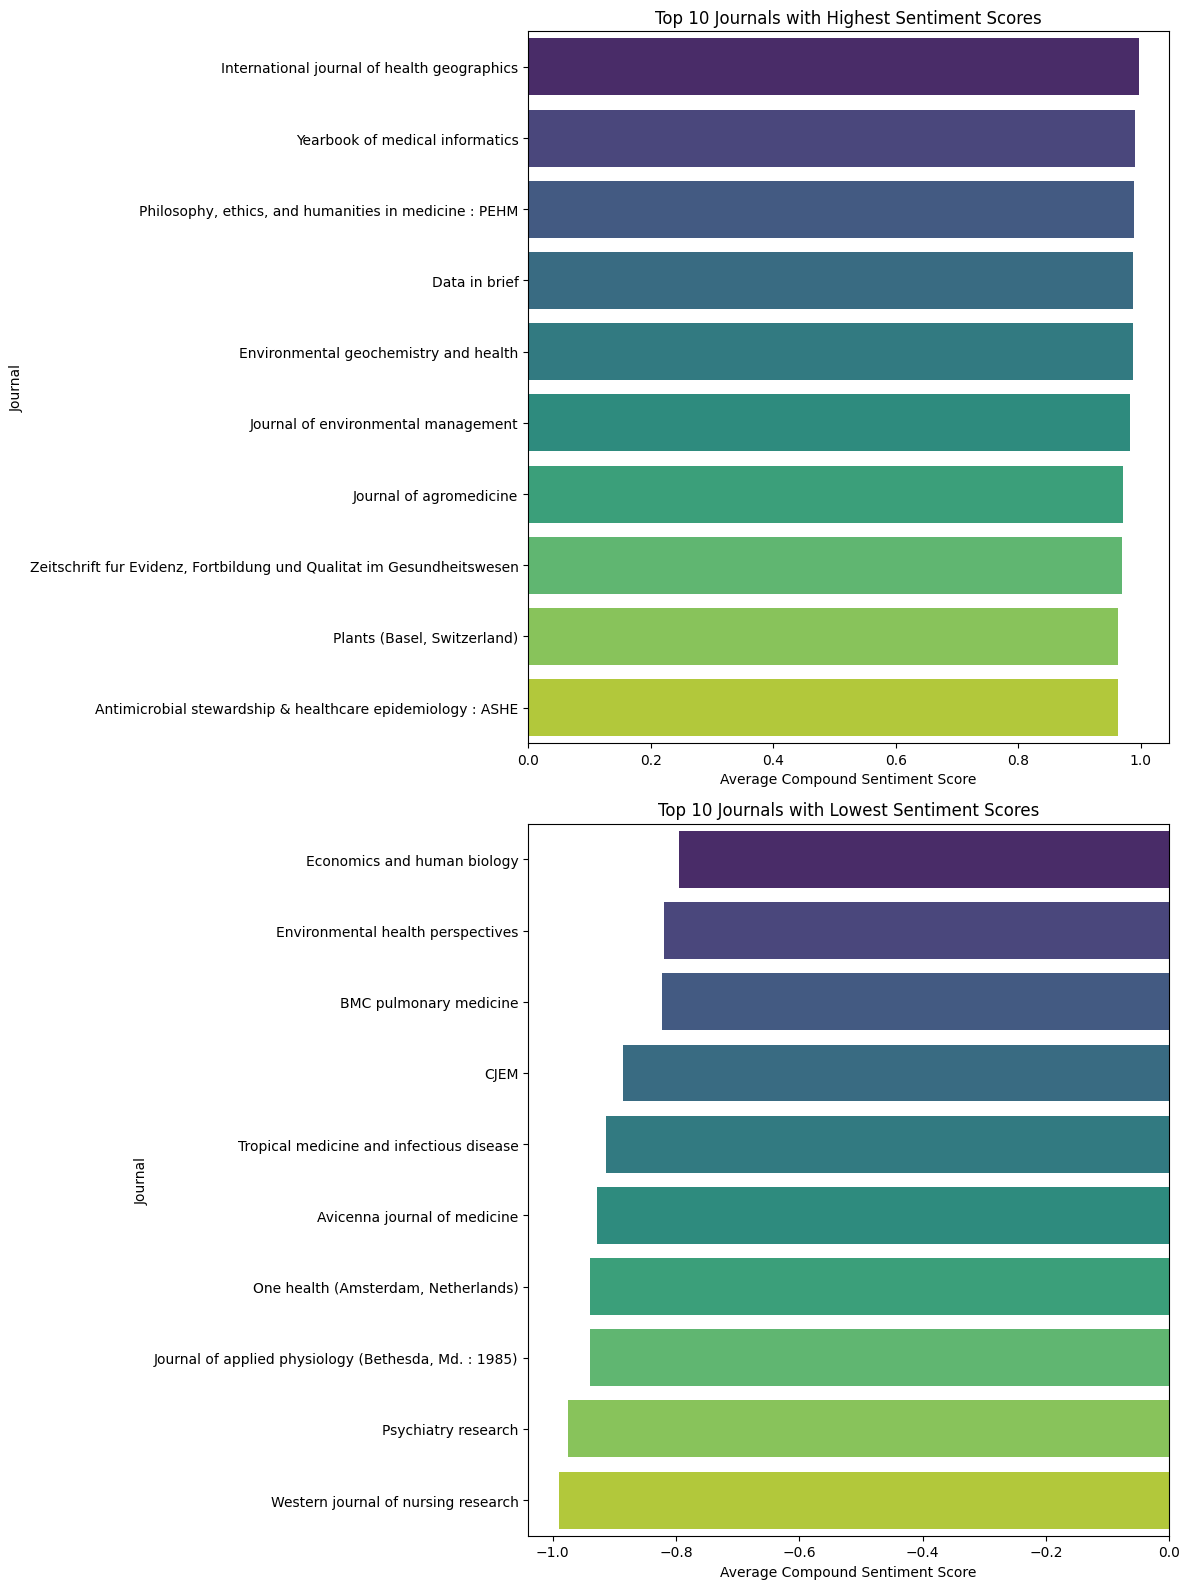

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_journal_sentiment(journal_sentiment_sorted):
    # Create a figure with two subplots
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 16))  # Adjusted figsize for consistent size

    # Plotting the top 10 journals with highest sentiment scores
    top_journals = journal_sentiment_sorted.head(10)
    sns.barplot(ax=axes[0], x='compound', y='Journal', data=top_journals, palette='viridis')
    axes[0].set_title('Top 10 Journals with Highest Sentiment Scores')
    axes[0].set_xlabel('Average Compound Sentiment Score')
    axes[0].set_ylabel('Journal')

    # Plotting the top 10 journals with lowest sentiment scores
    bottom_journals = journal_sentiment_sorted.tail(10)
    sns.barplot(ax=axes[1], x='compound', y='Journal', data=bottom_journals, palette='viridis')
    axes[1].set_title('Top 10 Journals with Lowest Sentiment Scores')
    axes[1].set_xlabel('Average Compound Sentiment Score')
    axes[1].set_ylabel('Journal')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage
visualize_journal_sentiment(journal_sentiment_sorted)



### Negative and Positive Sentiment Words

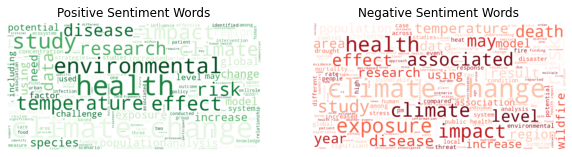

In [ ]:
from wordcloud import WordCloud

def generate_word_clouds(df):
    positive_texts = ' '.join(df[df['compound'] > 0]['processed_abstract_str'])
    negative_texts = ' '.join(df[df['compound'] < 0]['processed_abstract_str'])

    wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_texts)
    wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_texts)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_positive, interpolation='bilinear')
    plt.axis('off')
    plt.title('Positive Sentiment Words')

    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.axis('off')
    plt.title('Negative Sentiment Words')

    plt.show()

# Example usage
generate_word_clouds(df_combined)


### Top Positive and Negative Abstracts

In [ ]:
import pandas as pd
import xmltodict
import requests
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from IPython.display import display, HTML

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

stop_words = set(stopwords.words('english'))

def fetch_pubmed_ids(query, from_date, to_date, max_results=100):
    search_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    search_params = {
        "db": "pubmed",
        "term": query,
        "retmode": "json",
        "retmax": max_results,
        "mindate": from_date,
        "maxdate": to_date
    }
    response = requests.get(search_url, params=search_params)
    if response.status_code == 200:
        data = response.json()
        return data['esearchresult']['idlist']
    else:
        print(f"Error fetching PubMed IDs: {response.status_code} - {response.reason}")
        return []

def fetch_pubmed_details(ids, batch_size=100):
    fetch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    xml_data_list = []
    for i in range(0, len(ids), batch_size):
        batch_ids = ids[i:i + batch_size]
        fetch_params = {
            "db": "pubmed",
            "id": ",".join(batch_ids),
            "retmode": "xml"
        }
        response = requests.get(fetch_url, params=fetch_params)
        if response.status_code == 200:
            xml_data_list.append(response.text)
        else:
            print(f"Error fetching PubMed details for batch {i//batch_size + 1}: {response.status_code} - {response.reason}")
    return xml_data_list

def extract_text_from_abstract(abstract):
    if isinstance(abstract, list):
        text_list = []
        for item in abstract:
            if isinstance(item, dict):
                text_list.append(item.get('#text', ''))
            else:
                text_list.append(item)
        return ' '.join(text_list)
    elif isinstance(abstract, dict):
        return abstract.get('#text', '')
    else:
        return abstract

def parse_pubmed_details(xml_data_list):
    articles = []
    for xml_data in xml_data_list:
        data_dict = xmltodict.parse(xml_data)
        for article in data_dict['PubmedArticleSet']['PubmedArticle']:
            try:
                pmid = article['MedlineCitation']['PMID']
                title = article['MedlineCitation']['Article']['ArticleTitle']
                abstract = article['MedlineCitation']['Article']['Abstract']['AbstractText']
                abstract_text = extract_text_from_abstract(abstract)
                journal = article['MedlineCitation']['Article']['Journal']['Title']
                articles.append({
                    'PMID': pmid,
                    'Title': title,
                    'Abstract': abstract_text,
                    'Journal': journal
                })
            except KeyError as e:
                print(f"KeyError: {e} for PMID: {article['MedlineCitation'].get('PMID', 'N/A')}")
                continue
    return articles

def highlight_text(text, sentiment_scores):
    words = text.split()
    highlighted_text = []
    for word in words:
        score = sentiment_scores.get(word.lower(), 0)
        if score > 0:
            highlighted_text.append(f'<span style="color:green;">{word}</span>')
        elif score < 0:
            highlighted_text.append(f'<span style="color:red;">{word}</span>')
        else:
            highlighted_text.append(word)
    return ' '.join(highlighted_text)

# Fetch PubMed IDs and details
pubmed_ids = fetch_pubmed_ids('climate change health', '2023/01/01', '2023/12/31')
if not pubmed_ids:
    raise ValueError("No PubMed IDs fetched. Please check the query or date range.")

pubmed_xml = fetch_pubmed_details(pubmed_ids)
if not pubmed_xml:
    raise ValueError("Failed to fetch PubMed details. Please try again later.")

articles = parse_pubmed_details(pubmed_xml)
if not articles:
    raise ValueError("No articles parsed. Please check the fetching and parsing functions.")

df_articles = pd.DataFrame(articles)
if 'Abstract' not in df_articles.columns:
    raise KeyError("'Abstract' column is missing in the DataFrame. Please check the parsing logic.")
if 'Journal' not in df_articles.columns:
    raise KeyError("'Journal' column is missing in the DataFrame. Please check the parsing logic.")

# Sentiment Analysis
sia = SentimentIntensityAnalyzer()
df_articles['sentiment'] = df_articles['Abstract'].apply(lambda x: sia.polarity_scores(x))
df_articles['compound'] = df_articles['sentiment'].apply(lambda x: x['compound'])

# Highlighting sentiment in abstracts
df_articles['highlighted_abstract'] = df_articles.apply(
    lambda row: highlight_text(row['Abstract'], sia.lexicon), axis=1)

# Function to show examples with highlighted abstracts
def show_examples(df, sentiment_type='positive', top_n=5):
    if sentiment_type == 'positive':
        examples = df.nlargest(top_n, 'compound')
    else:
        examples = df.nsmallest(top_n, 'compound')

    for index, row in examples.iterrows():
        print(f"Journal: {row['Journal']}")
        print(f"Title: {row['Title']}")
        print(f"Abstract: {row['Abstract']}")
        print(f"Sentiment Score: {row['compound']}")
        print("Highlighted Abstract:")
        display(HTML(f"<p>{row['highlighted_abstract']}</p>"))
        print("="*80)

# Example usage
print("Top Positive Sentiment Abstracts:")
show_examples(df_articles, sentiment_type='positive', top_n=3)

print("Top Negative Sentiment Abstracts:")
show_examples(df_articles, sentiment_type='negative', top_n=3)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/cfitzpatrick/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cfitzpatrick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/cfitzpatrick/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


KeyError: 'Abstract' for PMID: {'@Version': '1', '#text': '38155040'}
KeyError: 'Abstract' for PMID: {'@Version': '1', '#text': '38149877'}
KeyError: 'Abstract' for PMID: {'@Version': '1', '#text': '38149642'}
KeyError: 'Abstract' for PMID: {'@Version': '1', '#text': '38145145'}
KeyError: 'Abstract' for PMID: {'@Version': '1', '#text': '38145132'}
KeyError: 'Abstract' for PMID: {'@Version': '1', '#text': '38126018'}
Top Positive Sentiment Abstracts:
Journal: International journal of health geographics
Title: Using geographic rescue time contours, point-of-care strategies, and spatial care paths to prepare island communities for global warming, rising oceans, and weather disasters.
Abstract: To perform geographic contour analysis of sea and land ambulance rescue times in an archipelago subject to super typhoons; to design point-of-care testing strategies for medical emergencies and weather disasters made more intense by global warming and rising oceans; and to assess needs for prehospit

Journal: Environmental science and pollution research international
Title: Unraveling interactions and priorities under sustainable development goals in less-developed mountainous areas: case study on the National Innovation Demonstration Zone for the 2030 Agenda for Sustainable Development, China.
Abstract: Understanding the intricate relationships between progress and the United Nations' 17 Sustainable Development Goals (SDGs) is vital for informed and adaptable sustainable development policy formulation. This study focused on the Lincang National Innovation Demonstration Zone for the 2030 Agenda for Sustainable Development (LC-NIDZASD) in China. By evaluating sustainability scores at the county level from 2011 to 2020, the trade-offs and synergies among SDGs were explored. Priority SDGs for development were identified, and targeted recommendations were established based on these findings. The key findings are as follows: (1) The SDG index scores of Lincang and its counties showed an

Journal: Yearbook of medical informatics
Title: Leveraging Data and Technology to Enhance Interdisciplinary Collaboration and Health Outcomes.
Abstract: To give an overview of recent research and propose a selection of best papers published in 2022 in Informatics for One Health. An extensive search using PubMed and Web of Science was conducted to identify peer-reviewed articles published between December 2021 and December 2022, in order to find relevant publications in the 'Informatics for One Health' field. The selection process comprised three steps: (i) eight candidate best papers were first selected by the two section editors; (ii) external reviewers from internationally renowned research teams reviewed each candidate best paper; and (iii) the editorial committee of the Yearbook conducted the final best paper selection. The candidate best papers represent studies that characterized significant challenges facing Informatics for One Health. Other trends of interest related to the dep

Top Negative Sentiment Abstracts:
Journal: Western journal of nursing research
Title: Cognitive Interview Validation of a Novel Household Hazard Vulnerability Assessment Instrument.
Abstract: Weather and climate disasters are responsible for over 13 000 US deaths, worsened morbidity, and $1.7 trillion in additional costs over the last 40 years with profound racial disparities. This project empirically generated items for a novel survey instrument of household hazard vulnerability with initial construct validation while addressing racial bias in the data collection process. Cognitive interviews facilitated understanding regarding the performance of drafted survey questions with transdisciplinary expert panelists from diverse US regions on unique hazard/disaster/event items. To prevent representation bias in data collection, those with Black and/or African American racial, biracial, or multiracial identities were over-sampled. Interview video recordings were qualitatively analyzed using 

Journal: Psychiatry research
Title: Mental illness and increased vulnerability to negative health effects from extreme heat events: a systematic review.
Abstract: Across countries, extreme heat events are projected to increase in frequency and intensity because of climate change. Exposure to extreme heat events can have a substantial negative impact on human health, and extant research suggests that individuals with mental illness are particularly vulnerable. To date, there has been no review of evidence regarding this vulnerability to inform response strategies and future research. A systematic review was undertaken to investigate mental illness as an effect modifier of the relationship between heat exposure and morbidity or mortality. Six databases (Medline, Embase, Global Health, PsychInfo, CINAHL and Scopus) were searched for studies published between the years 2000 to 2022. Twenty-two observational studies that met the inclusion criteria were investigated through narrative synthes

Journal: Environmental science & technology
Title: Excess Mortality Risk Due to Heat Stress in Different Climatic Zones of India.
Abstract: India is at a high risk of heat stress-induced health impacts and economic losses owing to its tropical climate, high population density, and inadequate adaptive planning. The health impacts of heat stress across climate zones in India have not been adequately explored. Here, we examine and report the vulnerability to heat stress in India using 42 years (1979-2020) of meteorological data from ERA-5 and developed climate-zone-specific percentile-based human comfort class thresholds. We found that the heat stress is usually 1-4 °C higher on heatwave (HW) days than on nonheatwave (NHW) days. However, the stress on NHW days remains considerable and cannot be neglected. We then showed the association of a newly formulated India heat index (IHI) with daily all-cause mortality in three cities - Delhi (semiarid), Varanasi (humid subtropical), and Chennai (

In [ ]:
#    if sentiment_type == 'positive':
#        examples = df.nlargest(top_n, 'compound')
#    else:
#        examples = df.nsmallest(top_n, 'compound')

#    for index, row in examples.iterrows():
#        print(f"Journal: {row['Journal']}")
#        print(f"Title: {row['Title']}")
#        print(f"Abstract: {row['Abstract']}")
#        print(f"Sentiment Score: {row['compound']}")
#        print("Highlighted Abstract:")
#        display(HTML(f"<p>{row['highlighted_abstract']}</p>"))
#        print("="*80)

# Example usage
#print("Top Positive Sentiment Abstracts:")
#show_examples(df_combined, sentiment_type='positive', top_n=3)

#print("Top Negative Sentiment Abstracts:")
#show_examples(df_combined, sentiment_type='negative', top_n=3)


In [ ]:
!pip install flask

In [ ]:
from flask import Flask, render_template, request
import pandas as pd
import xmltodict
import requests
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from IPython.display import HTML

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

app = Flask(__name__)

stop_words = set(nltk.corpus.stopwords.words('english'))

def fetch_pubmed_ids(query, from_date, to_date, max_results=100):
    search_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    search_params = {
        "db": "pubmed",
        "term": query,
        "retmode": "json",
        "retmax": max_results,
        "mindate": from_date,
        "maxdate": to_date
    }
    response = requests.get(search_url, params=search_params)
    if response.status_code == 200:
        data = response.json()
        return data['esearchresult']['idlist']
    else:
        print(f"Error fetching PubMed IDs: {response.status_code} - {response.reason}")
        return []

def fetch_pubmed_details(ids, batch_size=100):
    fetch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    xml_data_list = []
    for i in range(0, len(ids), batch_size):
        batch_ids = ids[i:i + batch_size]
        fetch_params = {
            "db": "pubmed",
            "id": ",".join(batch_ids),
            "retmode": "xml"
        }
        response = requests.get(fetch_url, params=fetch_params)
        if response.status_code == 200:
            xml_data_list.append(response.text)
        else:
            print(f"Error fetching PubMed details for batch {i//batch_size + 1}: {response.status_code} - {response.reason}")
    return xml_data_list

def extract_text_from_abstract(abstract):
    if isinstance(abstract, list):
        text_list = []
        for item in abstract:
            if isinstance(item, dict):
                text_list.append(item.get('#text', ''))
            else:
                text_list.append(item)
        return ' '.join(text_list)
    elif isinstance(abstract, dict):
        return abstract.get('#text', '')
    else:
        return abstract

def parse_pubmed_details(xml_data_list):
    articles = []
    for xml_data in xml_data_list:
        data_dict = xmltodict.parse(xml_data)
        for article in data_dict['PubmedArticleSet']['PubmedArticle']:
            try:
                pmid = article['MedlineCitation']['PMID']
                title = article['MedlineCitation']['Article']['ArticleTitle']
                abstract = article['MedlineCitation']['Article']['Abstract']['AbstractText']
                abstract_text = extract_text_from_abstract(abstract)
                journal = article['MedlineCitation']['Article']['Journal']['Title']
                articles.append({
                    'PMID': pmid,
                    'Title': title,
                    'Abstract': abstract_text,
                    'Journal': journal
                })
            except KeyError as e:
                print(f"KeyError: {e} for PMID: {article['MedlineCitation'].get('PMID', 'N/A')}")
                continue
    return articles

def highlight_text(text, sentiment_scores):
    words = text.split()
    highlighted_text = []
    for word in words:
        score = sentiment_scores.get(word.lower(), 0)
        if score > 0:
            highlighted_text.append(f'<span style="color:green;">{word}</span>')
        elif score < 0:
            highlighted_text.append(f'<span style="color:red;">{word}</span>')
        else:
            highlighted_text.append(word)
    return ' '.join(highlighted_text)

def show_examples(df, sentiment_type='positive', top_n=5):
    if sentiment_type == 'positive':
        examples = df.nlargest(top_n, 'compound')
    else:
        examples = df.nsmallest(top_n, 'compound')

    results = []
    for index, row in examples.iterrows():
        result = {
            'Journal': row['Journal'],
            'Title': row['Title'],
            'Abstract': row['Abstract'],
            'SentimentScore': row['compound'],
            'HighlightedAbstract': row['highlighted_abstract']
        }
        results.append(result)
    return results

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/results', methods=['POST'])
def results():
    query = request.form['query']
    from_date = request.form['from_date']
    to_date = request.form['to_date']

    pubmed_ids = fetch_pubmed_ids(query, from_date, to_date)
    pubmed_xml = fetch_pubmed_details(pubmed_ids)
    articles = parse_pubmed_details(pubmed_xml)
    df_articles = pd.DataFrame(articles)

    sia = SentimentIntensityAnalyzer()
    df_articles['sentiment'] = df_articles['Abstract'].apply(lambda x: sia.polarity_scores(x))
    df_articles['compound'] = df_articles['sentiment'].apply(lambda x: x['compound'])
    df_articles['highlighted_abstract'] = df_articles.apply(
        lambda row: highlight_text(row['Abstract'], sia.lexicon), axis=1)

    top_positive = show_examples(df_articles, sentiment_type='positive', top_n=3)
    top_negative = show_examples(df_articles, sentiment_type='negative', top_n=3)

    return render_template('results.html', positive_results=top_positive, negative_results=top_negative)

if __name__ == '__main__':
    app.run(debug=True)
